In [218]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib import colormaps
import matplotlib.pyplot as plt
import EpiClockInvasiveBRCA.src.util as epi_util
from EpiClockInvasiveBRCA.src.consts import consts

In [219]:
beta_values = {}
sample_map = {}
patients_bothSamplesPure = {}
samples_from_purePairs = {}
correlation_df = {}
LUMP_purity = {}

figure_outdir = os.path.join('figures', 'multi-sample')
if not os.path.exists(figure_outdir):
    os.mkdir(figure_outdir)

In [220]:
# Figure parameters

# scale factor
sf = 0.4

square_figsize = np.array([5, 4])
figsize = np.array([9, 7])
labelfontsize = 25
ticksfontsize = 18
opacity = 0.8
s = 50

sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')

## Primary-metastasis samples

In [221]:
proj_dir_reyn = os.path.join(consts['official_indir'], 'Reyngold')
proj_dir_auro = os.path.join(consts['official_indir'], 'Aurora')

sample_map['Reyngold'] = pd.read_table(os.path.join(proj_dir_reyn, 'sample_map.txt'), index_col=0)
sample_map['Reyngold'] = sample_map['Reyngold'].rename(columns={'unique patient id':'Patient', 'sample type':'Sample Type'})
sample_map['Reyngold']['Sample Type'] = sample_map['Reyngold']['Sample Type'].map({'primary tumor':'Primary', 'lymph node metastasis':'Metastasis'})
patients_bothSamplesPure['Reyngold'] = np.loadtxt(os.path.join(proj_dir_reyn, 'patients_bothSamplesPure.txt'), dtype=str)
beta_values['Reyngold'] = pd.read_table(os.path.join(proj_dir_reyn, 'beta_values_balanced_CpGs_pureSamples.txt'), index_col=0)
samples_from_purePairs['Reyngold'] = sample_map['Reyngold'].index[sample_map['Reyngold']['Patient'].isin(patients_bothSamplesPure['Reyngold'])].values
LUMP_purity['Reyngold'] = pd.read_table(os.path.join(proj_dir_reyn, 'LUMP_purity.txt'), index_col=0).squeeze('columns')

sample_map['Aurora'] = pd.read_table(os.path.join(proj_dir_auro, 'sample_map.txt'), index_col=0)
patients_bothSamplesPure['Aurora'] = np.loadtxt(os.path.join(proj_dir_auro, 'patients_bothSamplesPure.txt'), dtype=str)
beta_values['Aurora'] = pd.read_table(os.path.join(proj_dir_auro, 'beta_values_Clock_CpGs_pureSamples.txt'), index_col=0)
samples_from_purePairs['Aurora'] = sample_map['Aurora'].index[sample_map['Aurora']['Patient'].isin(patients_bothSamplesPure['Aurora'])].values
LUMP_purity['Aurora'] = pd.read_table(os.path.join(proj_dir_auro, 'LUMP_purity.txt'), index_col=0).squeeze('columns')

sample_map['combined'] = pd.concat([sample_map['Reyngold'], sample_map['Aurora']], axis=0)
patients_bothSamplesPure['combined'] = np.concatenate([patients_bothSamplesPure['Reyngold'], patients_bothSamplesPure['Aurora']])
beta_values['combined'] = pd.concat([beta_values['Reyngold'], beta_values['Aurora']], axis=1)
samples_from_purePairs['combined'] = np.concatenate([samples_from_purePairs['Reyngold'], samples_from_purePairs['Aurora']])
LUMP_purity['combined'] = pd.concat([LUMP_purity['Reyngold'], LUMP_purity['Aurora']], axis=0)

In [222]:
def getCorrelationDF(samples_from_purePairs, beta_values, sample_map):
    correlation_df = pd.DataFrame(index=samples_from_purePairs, columns=samples_from_purePairs, data=float('nan'))
    n_GSMs = correlation_df.shape[0]

    for i in range(n_GSMs):
        GSM_i = samples_from_purePairs[i]
        correlation_df.loc[GSM_i, GSM_i] = 1
        for j in range(i+1, n_GSMs):
            GSM_j = samples_from_purePairs[j]
            res = epi_util.pearsonCorrelation(beta_values[GSM_i], beta_values[GSM_j])
            correlation_df.loc[GSM_i, GSM_j] = res.rvalue
            correlation_df.loc[GSM_j, GSM_i] = res.rvalue
    
    sample_map_copy = sample_map[['Patient', 'Sample Type']].copy()
    sample_map_copy['Sample Type'] = sample_map_copy['Sample Type'].map({'Primary':'Tum', 'Metastasis':'Met'})
    GSM_to_heatmap_label_mapper = sample_map_copy.loc[samples_from_purePairs].apply(lambda x:': '.join(x), axis=1)
    correlation_df = correlation_df.rename(columns=GSM_to_heatmap_label_mapper).rename(index=GSM_to_heatmap_label_mapper)

    return correlation_df

In [223]:
correlation_df['Reyngold'] = getCorrelationDF(samples_from_purePairs['Reyngold'], beta_values['Reyngold'], sample_map['Reyngold'])
correlation_df['Aurora'] = getCorrelationDF(samples_from_purePairs['Aurora'], beta_values['Aurora'], sample_map['Aurora'])
correlation_df['combined'] = getCorrelationDF(samples_from_purePairs['combined'], beta_values['combined'], sample_map['combined'])

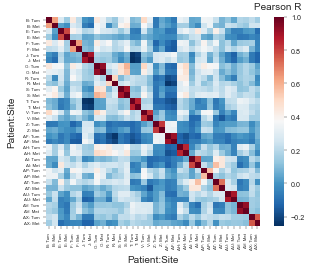

In [224]:
cohort = 'Reyngold'

fig, ax = plt.subplots(figsize=square_figsize * 2.4 * sf)

cmap = colormaps['RdBu'].reversed()
cmap.set_bad('lightgray', 1.)
sns.heatmap(ax=ax, data=correlation_df[cohort], cmap=cmap, cbar_kws={'label':'Pearson R'})
cbar_ax = ax.figure.axes[-1]
cbar_ax.yaxis.label.set_size(labelfontsize * sf)
cbar_ax.tick_params(labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

cbar_ax.set_ylabel(cbar_ax.get_ylabel(), rotation=0)
cbar_ax.yaxis.set_label_coords(0.4, 1.07)

ax.set_xlabel('Patient:Site', fontsize=labelfontsize * sf)
ax.set_ylabel('Patient:Site', fontsize=labelfontsize * sf)
ax.xaxis.set_label_coords(0.5, -0.14)
ax.yaxis.set_label_coords(-0.14, 0.5)

ax.tick_params(axis='both', labelsize=ticksfontsize * 0.6 * sf, width=sf, length=8 * sf)
ticks = np.sort(np.concatenate([ax.get_xticks(), ax.get_xticks() + 1]))
ax.set_xticks(ticks, correlation_df[cohort].index)
ax.set_yticks(ticks, correlation_df[cohort].index)

fig.savefig(os.path.join(figure_outdir, 'prim-met_heatmap.pdf'), format='pdf', pad_inches=0.1)

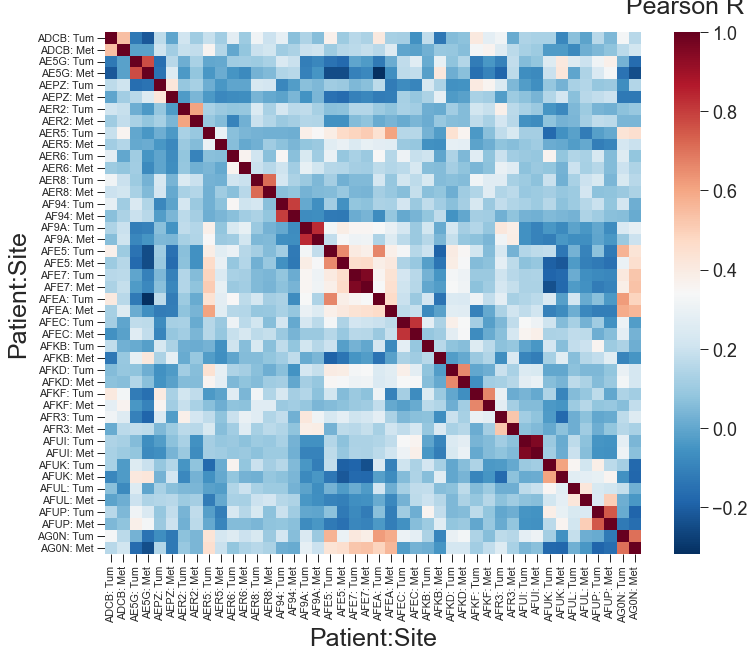

In [225]:
cohort = 'Aurora'
sf = 1

fig, ax = plt.subplots(figsize=square_figsize * 2.4 * sf)

cmap = colormaps['RdBu'].reversed()
cmap.set_bad('lightgray', 1.)
sns.heatmap(ax=ax, data=correlation_df[cohort], cmap=cmap, cbar_kws={'label':'Pearson R'})
cbar_ax = ax.figure.axes[-1]
cbar_ax.yaxis.label.set_size(labelfontsize * sf)
cbar_ax.tick_params(labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

cbar_ax.set_ylabel(cbar_ax.get_ylabel(), rotation=0)
cbar_ax.yaxis.set_label_coords(0.4, 1.07)

ax.set_xlabel('Patient:Site', fontsize=labelfontsize * sf)
ax.set_ylabel('Patient:Site', fontsize=labelfontsize * sf)
ax.xaxis.set_label_coords(0.5, -0.14)
ax.yaxis.set_label_coords(-0.14, 0.5)

ax.tick_params(axis='both', labelsize=ticksfontsize * 0.6 * sf, width=sf, length=8 * sf)
# ticks = np.sort(np.concatenate([ax.get_xticks(), ax.get_xticks() + 1]))
# ax.set_xticks(ticks, correlation_df[cohort].index)
# ax.set_yticks(ticks, correlation_df[cohort].index)

# fig.savefig(os.path.join(figure_outdir, 'prim-met_heatmap.pdf'), format='pdf', pad_inches=0.1)

In [226]:
## Significant difference between between-patient correlations and same-patient correlations

def statisticsCorrelationDF(correlation_df):
    same_patient_r = []
    diff_patient_r = []

    samples = correlation_df.index
    n_samps = len(samples)
    for i in range(n_samps - 1):
        samp_i = samples[i]
        patient_i = samp_i.split(':')[0]
        for j in range(i + 1, n_samps):
            samp_j = samples[j]
            patient_j = samp_j.split(':')[0]
            rvalue = correlation_df.loc[samp_i, samp_j]

            if patient_i == patient_j:
                same_patient_r.append(rvalue)
            else:
                diff_patient_r.append(rvalue)

    pvalue = epi_util.ranksums(same_patient_r, diff_patient_r).pvalue
    return np.median(same_patient_r), np.median(diff_patient_r), pvalue

med_same_patient_r, med_diff_patient_r, pvalue = statisticsCorrelationDF(correlation_df['Reyngold'])

print('Reyngold')
print(f'\tMedian within-patient correlation: {med_same_patient_r:.2f}')
print(f'\tMedian between-patient correlation: {med_diff_patient_r:.2f}')
print(f'\tWilcoxon rank sum test: P = {pvalue:.0e}')

med_same_patient_r, med_diff_patient_r, pvalue = statisticsCorrelationDF(correlation_df['Aurora'])

print('Aurora')
print(f'\tMedian within-patient correlation: {med_same_patient_r:.2f}')
print(f'\tMedian between-patient correlation: {med_diff_patient_r:.2f}')
print(f'\tWilcoxon rank sum test: P = {pvalue:.0e}')


med_same_patient_r, med_diff_patient_r, pvalue = statisticsCorrelationDF(correlation_df['combined'])

print('Combined')
print(f'\tMedian within-patient correlation: {med_same_patient_r:.2f}')
print(f'\tMedian between-patient correlation: {med_diff_patient_r:.2f}')
print(f'\tWilcoxon rank sum test: P = {pvalue:.0e}')

Reyngold
	Median within-patient correlation: 0.82
	Median between-patient correlation: 0.14
	Wilcoxon rank sum test: P = 5e-13
Aurora
	Median within-patient correlation: 0.66
	Median between-patient correlation: 0.10
	Wilcoxon rank sum test: P = 3e-14
Combined
	Median within-patient correlation: 0.73
	Median between-patient correlation: 0.08
	Wilcoxon rank sum test: P = 2e-26


In [227]:
cohort = 'combined'

c_beta = 1 - beta_values[cohort].std(axis=0)
c_beta_by_patient = sample_map[cohort].reset_index().pivot(index='Patient', columns='Sample Type', values='index')
c_beta_by_patient['Metastasis'] = c_beta_by_patient['Metastasis'].map(c_beta)
c_beta_by_patient['Primary'] = c_beta_by_patient['Primary'].map(c_beta)
c_beta_by_patient = c_beta_by_patient.loc[patients_bothSamplesPure[cohort]]

LUMP_purity_by_patient = sample_map[cohort].reset_index().pivot(index='Patient', columns='Sample Type', values='index').loc[patients_bothSamplesPure[cohort]]
LUMP_purity_by_patient['Primary'] = LUMP_purity_by_patient['Primary'].map(LUMP_purity[cohort])
LUMP_purity_by_patient['Metastasis'] = LUMP_purity_by_patient['Metastasis'].map(LUMP_purity[cohort])

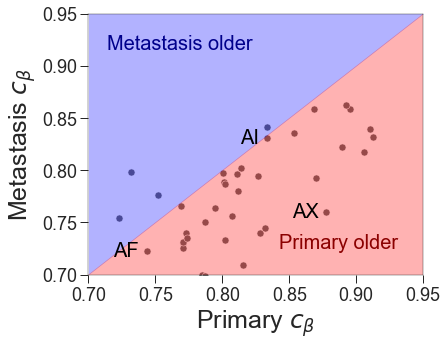

In [228]:

fig, ax = plt.subplots(figsize=square_figsize * 1.2 * sf)

# pts_range = (c_beta_by_patient.min().min()*0.95, c_beta_by_patient.max().max()*1.05)
pts_range = (0.7, 0.95)
pts_arr = np.linspace(pts_range[0], pts_range[1], 100)

sns.scatterplot(ax=ax, data=c_beta_by_patient, x='Primary', y='Metastasis', color='dimgray',
               s=s * sf)

ax.set_xlim(pts_range[0], pts_range[1])
ax.set_ylim(pts_range[0], pts_range[1])

ax.fill_between(pts_range, pts_range, 1, alpha=0.3, color='blue', lw=0)
ax.fill_between(pts_range, 0, pts_range, alpha=0.3, color='red', lw=0)

ax.set_xlabel(ax.get_xlabel().capitalize() + ' $c_β$', fontsize=labelfontsize * sf)
ax.set_ylabel(ax.get_ylabel().capitalize() + ' $c_β$', fontsize=labelfontsize * sf)
ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

ax.text(pts_range[0]*1.02, pts_range[1]*0.96, 'Metastasis older',
        ha="left", va="bottom", fontfamily='sans-serif', color='darkblue',
        fontsize=labelfontsize * 0.8 * sf)
ax.text(pts_range[1]*0.98, pts_range[0]*1.03, 'Primary older',
        ha="right", va="bottom", fontfamily='sans-serif', color='darkred',
        fontsize=labelfontsize * 0.8 * sf)

for patient in ['AF', 'AX', 'AI']:
    xpos = c_beta_by_patient.loc[patient, 'Primary']
    ypos = c_beta_by_patient.loc[patient, 'Metastasis']
    ax.text(xpos-0.006, ypos, patient,
            ha="right", va="center", fontfamily='sans-serif', color='black',
            fontsize=labelfontsize * 0.8 * sf)

# fig.savefig(os.path.join(figure_outdir, 'prim-met_age_comparison.pdf'), format='pdf', pad_inches=0.1)

Text(0.1, 0.95, 'R = -0.35')

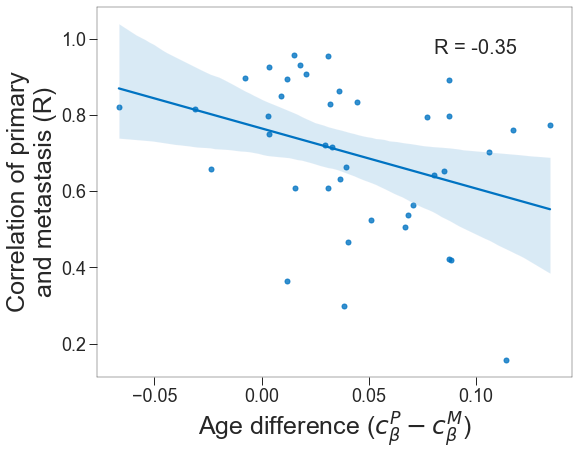

In [229]:
rvalue_list = [correlation_df[cohort].loc[f'{patient}: Tum', f'{patient}: Met'] for patient in patients_bothSamplesPure[cohort]]
rvalue_ser = pd.Series(index=patients_bothSamplesPure[cohort], data=rvalue_list).rename('R')
c_beta_diff = (c_beta_by_patient['Primary'] - c_beta_by_patient['Metastasis']).rename('c_beta_diff')

plot_data = pd.concat([rvalue_ser, c_beta_diff], axis=1)
R = epi_util.pearsonCorrelation(plot_data['c_beta_diff'], plot_data['R']).rvalue

fig, ax = plt.subplots(figsize=square_figsize * 1.7 * sf)

sns.regplot(ax=ax, data=plot_data, x='c_beta_diff', y='R', color=consts['palette_jco'][0], scatter_kws={'s':s * 0.5 * sf})


ax.set_xlabel('Age difference ($c_β^P - c_β^M$)', fontsize=labelfontsize * sf)
ax.set_ylabel('Correlation of primary\nand metastasis (R)', fontsize=labelfontsize * sf)
ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

ax.text(0.1, 0.95, f'R = {R:.2f}',
                        ha="center", va="bottom",
                        fontfamily='sans-serif', fontsize=0.8 * labelfontsize * sf)

# fig.savefig(os.path.join(figure_outdir, 'prim-met_corr_vs_age_diff.pdf'), format='pdf', pad_inches=0.1)

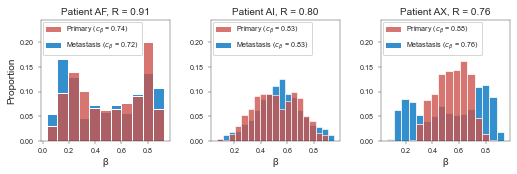

In [230]:
sf = 0.4

patient_list = ['AF', 'AI', 'AX']
#patient_list = patients_bothSamplesPure

nsamps = len(patient_list)
ncols = 3
nrows = 1

fig, axes = plt.subplots(nrows, ncols, figsize=figsize * [2, 0.8] * sf)
fig.tight_layout(pad=0.7)

color_dict = {'primary':consts['palette_jco'][3], 'metastasis':consts['palette_jco'][0]}

for i, patient in enumerate(patient_list):
    samp_prim = sample_map['Reyngold'].index[(sample_map['Reyngold']['Patient'] == patient) & (sample_map['Reyngold']['Sample Type'] == 'Primary')].values[0]
    samp_met = sample_map['Reyngold'].index[(sample_map['Reyngold']['Patient'] == patient) & (sample_map['Reyngold']['Sample Type'] == 'Metastasis')].values[0]
    df_prim = beta_values['Reyngold'][samp_prim].rename('beta').to_frame()
    df_met = beta_values['Reyngold'][samp_met].rename('beta').to_frame()
    df_prim['Sample Type'] = 'primary'
    df_met['Sample Type'] = 'metastasis'
    df = pd.concat([df_prim, df_met], axis=0, ignore_index=True)
    
    col = i % ncols
    if nrows == 1:
        ax = axes[col]
    else:
        row = int(i / ncols)
        ax = axes[row, col]
        
#     legend = i == 0
    legend = False
    sns.histplot(ax=ax, data=df, x='beta', hue='Sample Type', common_norm=False, legend=legend, stat='proportion',
                 palette=color_dict, alpha=opacity)
    
    if i == 0:
        ax.set_ylabel(ax.get_ylabel(), fontsize=labelfontsize * sf)
        
#         patches = [mpatches.Patch(color=color_dict[kind], label=kind.capitalize(),
#                                   alpha=opacity, linewidth=0)
#                    for kind in color_dict.keys()]
#         plots_x, plots_y = ax.get_position().get_points()[1]
#         fig.legend(handles=patches,
#            loc='center',
#            bbox_to_anchor=(0.19, 0.77),
#            fontsize=ticksfontsize * sf,
#            frameon=True
#           )
    else:
        ax.set_ylabel('')
    
    patches = [mpatches.Patch(color=color_dict['primary'], label=f'Primary ($c_β$ = {c_beta_by_patient.loc[patient, "Primary"]:.2f})',
                              alpha=opacity, linewidth=0),
               mpatches.Patch(color=color_dict['metastasis'], label=f'Metastasis ($c_β$ = {c_beta_by_patient.loc[patient, "Metastasis"]:.2f})',
                              alpha=opacity, linewidth=0)]
    plots_x, plots_y = ax.get_position().get_points()[1]
    ax.legend(handles=patches,
       loc='center',
       bbox_to_anchor=(0.4, 0.85),
       fontsize=ticksfontsize * sf,
       frameon=True
      )
    
    rvalue = epi_util.pearsonCorrelation(df_prim['beta'], df_met['beta']).rvalue
    ax.set_xlabel('β', fontsize=labelfontsize * sf)
    ax.set_title(f'Patient {patient}, R = {rvalue:.2f}', fontsize=labelfontsize * sf)
    ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

    ax.set_ylim(0, 0.245)

fig.savefig(os.path.join(figure_outdir, 'prim-met-hists.pdf'), format='pdf', pad_inches=0.1)

LinregressResult(slope=0.24685650678296236, intercept=0.025052740550511855, rvalue=0.5685251087706561, pvalue=0.00012957065654838678, stderr=0.057946423003781125, intercept_stderr=0.007026334606935211)

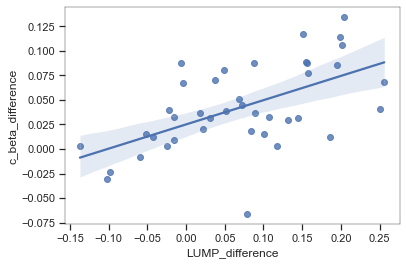

In [231]:
df = pd.concat([
    (c_beta_by_patient['Primary'] - c_beta_by_patient['Metastasis']).rename('c_beta_difference'),
    (LUMP_purity_by_patient['Metastasis'] - LUMP_purity_by_patient['Primary']).rename('LUMP_difference')
], axis=1)
sns.regplot(data=df, x='LUMP_difference', y='c_beta_difference')
epi_util.pearsonCorrelation(df['LUMP_difference'], df['c_beta_difference'])

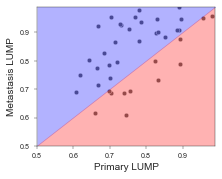

In [191]:
LUMP_purity_by_patient = LUMP_purity_by_patient.loc[patients_bothSamplesPure[cohort]]

fig, ax = plt.subplots(figsize=square_figsize * 1.6 * sf)

# pts_range = (c_beta_by_patient.min().min()*0.95, c_beta_by_patient.max().max()*1.05)
pts_range = (0.5, 0.99)
pts_arr = np.linspace(pts_range[0], pts_range[1], 100)

sns.scatterplot(ax=ax, data=LUMP_purity_by_patient, x='Primary', y='Metastasis', color='dimgray',
               s=s * sf)

ax.set_xlim(pts_range[0], pts_range[1])
ax.set_ylim(pts_range[0], pts_range[1])

ax.fill_between(pts_range, pts_range, 1, alpha=0.3, color='blue', lw=0)
ax.fill_between(pts_range, 0, pts_range, alpha=0.3, color='red', lw=0)

ax.set_xlabel(ax.get_xlabel().capitalize() + ' LUMP', fontsize=labelfontsize * sf)
ax.set_ylabel(ax.get_ylabel().capitalize() + ' LUMP', fontsize=labelfontsize * sf)
ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)


## Bifocal tumor samples

In [28]:
proj_dir = os.path.join(consts['official_indir'], 'Desmedt')

sample_map['Desmedt'] = pd.read_table(os.path.join(proj_dir, 'sample_annotations_clean.txt'), index_col=0, dtype=str)
patients_bothSamplesPure['Desmedt'] = np.loadtxt(os.path.join(proj_dir, 'patients_bothSamplesPure.txt'), dtype=str)
beta_values['Desmedt'] = pd.read_table(os.path.join(proj_dir, 'beta_values_balanced_CpGs_pureSamples.txt'), index_col=0)
samples_from_purePairs['Desmedt'] = sample_map['Desmedt'].index[sample_map['Desmedt']['patient'].isin(patients_bothSamplesPure['Desmedt'])].values

In [29]:
correlation_df = pd.DataFrame(index=samples_from_purePairs['Desmedt'], columns=samples_from_purePairs['Desmedt'], data=float('nan'))
n_GSMs = correlation_df.shape[0]

for i in range(n_GSMs):
    GSM_i = samples_from_purePairs['Desmedt'][i]
    correlation_df.loc[GSM_i, GSM_i] = 1
    for j in range(i+1, n_GSMs):
        GSM_j = samples_from_purePairs['Desmedt'][j]
        ser_i = beta_values['Desmedt'][GSM_i]
        ser_j = beta_values['Desmedt'][GSM_j]
        res, n_used = epi_util.pearsonCorrelation(ser_i, ser_j, get_n_used=True)
        if n_used >= 10:
            correlation_df.loc[GSM_i, GSM_j] = res.rvalue
            correlation_df.loc[GSM_j, GSM_i] = res.rvalue

In [30]:
GSM_to_heatmap_label_mapper = sample_map['Desmedt'].loc[samples_from_purePairs['Desmedt'], ['patient', 'foci']].apply(lambda x:':'.join(x), axis=1)
correlation_df = correlation_df.rename(columns=GSM_to_heatmap_label_mapper).rename(index=GSM_to_heatmap_label_mapper)

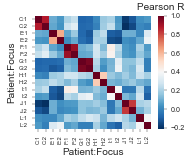

In [39]:
fig, ax = plt.subplots(figsize=square_figsize * 1.3 * sf)

cmap = colormaps['RdBu'].reversed()
cmap.set_bad('lightgray', 1.)
sns.heatmap(ax=ax, data=correlation_df, cmap=cmap, cbar_kws={'label':'Pearson R'})
cbar_ax = ax.figure.axes[-1]
cbar_ax.yaxis.label.set_size(labelfontsize * sf)
cbar_ax.tick_params(labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

cbar_ax.set_ylabel(cbar_ax.get_ylabel(), rotation=0)
cbar_ax.yaxis.set_label_coords(0.4, 1.11)

# ax.set_title('Cohort T3 Intrapatient Methylation Correlation', fontsize=20)
ax.set_xlabel('Patient:Focus', fontsize=labelfontsize * sf)
ax.set_ylabel('Patient:Focus', fontsize=labelfontsize * sf)
ax.xaxis.set_label_coords(0.5, -0.17)
ax.yaxis.set_label_coords(-0.16, 0.5)

ax.tick_params(axis='both', labelsize=ticksfontsize * 0.8 * sf, width=sf, length=8 * sf)
ticks = np.sort(np.concatenate([ax.get_xticks(), ax.get_xticks() + 1]))
ax.set_xticks(ticks, correlation_df.index)
ax.set_yticks(ticks, correlation_df.index)

fig.savefig(os.path.join(figure_outdir, 'bifocal_heatmap.pdf'), format='pdf', pad_inches=0.1)

In [142]:
## Significant difference between between-patient correlations and same-patient correlations

same_patient_r = []
diff_patient_r = []

samples = correlation_df.index
n_samps = len(samples)
for i in range(n_samps - 1):
    samp_i = samples[i]
    patient_i = samp_i.split(':')[0]
    for j in range(i + 1, n_samps):
        samp_j = samples[j]
        patient_j = samp_j.split(':')[0]
        rvalue = correlation_df.loc[samp_i, samp_j]
        
        if patient_i == patient_j:
            same_patient_r.append(rvalue)
        else:
            diff_patient_r.append(rvalue)

pvalue = epi_util.ranksums(same_patient_r, diff_patient_r).pvalue

print(f'Median within-patient correlation: {np.median(same_patient_r):.2f}')
print(f'Median between-patient correlation: {np.median(diff_patient_r):.2f}')
print(f'Wilcoxon rank sum test: P = {pvalue:.0e}')

Median within-patient correlation: 0.72
Median between-patient correlation: 0.10
Wilcoxon rank sum test: p = 3e-06


In [83]:
c_beta = 1 - beta_values['Desmedt'].std(axis=0)
c_beta_by_patient = sample_map['Desmedt'].reset_index().pivot(index='patient', columns='foci', values='index').loc[patients_bothSamplesPure['Desmedt']]
c_beta_by_patient['1'] = c_beta_by_patient['1'].map(c_beta)
c_beta_by_patient['2'] = c_beta_by_patient['2'].map(c_beta)

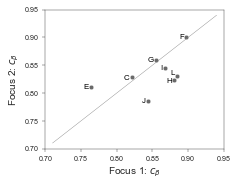

In [93]:
fig, ax = plt.subplots(figsize=square_figsize * 1.6 * sf)

# pts_range = (c_beta_by_patient.min().min()*0.98, c_beta_by_patient.max().max()*1.02)
pts_range = (0.7, 0.95)
pts_arr = np.linspace(pts_range[0], pts_range[1], 100)

sns.scatterplot(ax=ax, data=c_beta_by_patient, x='1', y='2', color='dimgray', s=s * sf)

ax.set_xlabel('Focus 1: $c_β$', fontsize=labelfontsize * sf)
ax.set_ylabel('Focus 2: $c_β$', fontsize=labelfontsize * sf)
ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

ax.set_xlim(pts_range[0], pts_range[1])
ax.set_ylim(pts_range[0], pts_range[1])

ax.plot(pts_arr[4:-4], pts_arr[4:-4], color="grey", linestyle='solid', linewidth=1.0 * sf)

offset_y = {'L':0.005}

for patient in c_beta_by_patient.index:
    xpos = c_beta_by_patient.loc[patient, '1']
    ypos = c_beta_by_patient.loc[patient, '2']
    if patient in offset_y:
        ypos += offset_y[patient]
    ax.text(xpos-0.003, ypos, patient,
            ha="right", va="center", fontfamily='sans-serif', color='black',
            fontsize=labelfontsize * 0.8 * sf)

plt.savefig(os.path.join(figure_outdir, 'bifocal_age_comparison.pdf'), format='pdf')

In [90]:
LUMP_purity = pd.read_table(os.path.join(proj_dir, 'LUMP_purity.txt'), index_col=0).squeeze('columns')
LUMP_purity_by_patient = sample_map['Desmedt'].reset_index().pivot(index='patient', columns='foci', values='index').loc[patients_bothSamplesPure['Desmedt']]
LUMP_purity_by_patient['1'] = LUMP_purity_by_patient['1'].map(LUMP_purity)
LUMP_purity_by_patient['2'] = LUMP_purity_by_patient['2'].map(LUMP_purity)

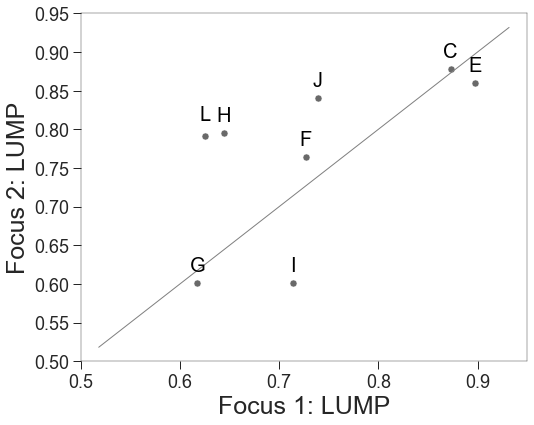

In [104]:
sf = 1

fig, ax = plt.subplots(figsize=square_figsize * 1.6 * sf)

# pts_range = (c_beta_by_patient.min().min()*0.98, c_beta_by_patient.max().max()*1.02)
pts_range = (0.5, 0.95)
pts_arr = np.linspace(pts_range[0], pts_range[1], 100)

sns.scatterplot(ax=ax, data=LUMP_purity_by_patient, x='1', y='2', color='dimgray', s=s * sf)

ax.set_xlabel('Focus 1: LUMP', fontsize=labelfontsize * sf)
ax.set_ylabel('Focus 2: LUMP', fontsize=labelfontsize * sf)
ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

ax.set_xlim(pts_range[0], pts_range[1])
ax.set_ylim(pts_range[0], pts_range[1])

ax.plot(pts_arr[4:-4], pts_arr[4:-4], color="grey", linestyle='solid', linewidth=1.0 * sf)

# offset_y = {'L':0.005}

for patient in LUMP_purity_by_patient.index:
    xpos = LUMP_purity_by_patient.loc[patient, '1']
    ypos = LUMP_purity_by_patient.loc[patient, '2']
    if patient in offset_y:
        ypos += offset_y[patient]
    ax.text(xpos, ypos+0.01, patient,
            ha="center", va="bottom", fontfamily='sans-serif', color='black',
            fontsize=labelfontsize * 0.8 * sf)


<Axes: xlabel='LUMP', ylabel='c_beta'>

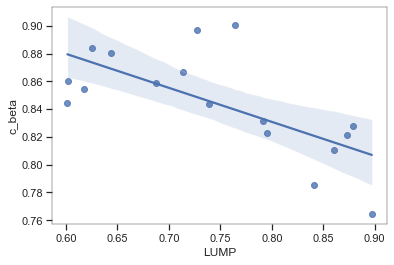

In [103]:
plot_data = pd.concat([LUMP_purity.rename('LUMP'), c_beta.rename('c_beta')], axis=1)

sns.regplot(data=plot_data, x='LUMP', y='c_beta')